In [2]:
# Basic Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Scikit-learn: Data Splitting, Preprocessing, Evaluation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Scikit-learn: Regression Models
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor

# Boosting Libraries
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# SciPy: Optimization
from scipy.optimize import minimize

# PyTorch: Model Training and Utilities
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import random
import numpy as np
import torch
import os

def set_seed(seed=42):
    random.seed(seed)                      
    np.random.seed(seed)                   
    torch.manual_seed(seed)                
    torch.cuda.manual_seed(seed)           
    torch.cuda.manual_seed_all(seed)       

    torch.backends.cudnn.deterministic = True   
    torch.backends.cudnn.benchmark = False      

    os.environ['PYTHONHASHSEED'] = str(seed)    

# 사용 예시
set_seed(42)
g = torch.Generator()

g.manual_seed(42)

In [3]:
df = pd.read_csv("chemical.csv")
df_ctrl = pd.read_csv("chemical_control_features.csv")


In [4]:
waste_col = 'Y.ECH.yecfick204.pv//PVC WASTE WATER TO TK204_PV'

X_ech = df.drop(columns=['ECH_target', waste_col])
y_ech = df['ECH_target']

X_waste = df.drop(columns=[waste_col,'ECH_target']) 
y_waste = df[waste_col]
X_train_ech, X_test_ech, y_train_ech, y_test_ech = train_test_split(
    X_ech, y_ech, test_size=0.3, random_state=42, shuffle=True
)

X_train_waste, X_test_waste, y_train_waste, y_test_waste = train_test_split(
    X_waste, y_waste, test_size=0.3, random_state=42, shuffle=True
)



In [5]:
class Net(nn.Module):
    def __init__(self, d_in):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_in, 64), nn.ReLU(),
            nn.Linear(64, 128), nn.ReLU(),
            nn.Linear(128, 1),
        )
    def forward(self, x): return self.net(x)

def to_prob_dist(x, eps=1e-8):
    x_shift = x - torch.min(x) + eps
    return x_shift / (x_shift.sum() + eps)

def js_div(p, q, eps=1e-8):
    p_prob = to_prob_dist(p)
    q_prob = to_prob_dist(q)
    m = 0.5 * (p_prob + q_prob)
    kl_pm = torch.sum(p_prob * torch.log((p_prob + eps) / (m + eps)))
    kl_qm = torch.sum(q_prob * torch.log((q_prob + eps) / (m + eps)))
    return 0.5 * (kl_pm + kl_qm)

def custom_loss(y_pred, y_true, lam=0.5):
    mse = nn.MSELoss()(y_pred, y_true)
    y_max, y_min = y_true.max(), y_true.min()
    y_not = y_max + y_min - y_true
    D_js_y_yhat = js_div(y_true.view(-1), y_pred.view(-1))
    D_js_y_ynot = js_div(y_true.view(-1), y_not.view(-1))
    pmc_term = D_js_y_yhat / (D_js_y_ynot + 1e-8)
    return mse + lam * pmc_term

def train_pmc_model(X_train, y_train, X_test, y_test, model_save_path, lam_value=1.0, epochs=500, patience=30):
   
    x_scaler = StandardScaler()
    X_train_scaled = x_scaler.fit_transform(X_train)
    X_test_scaled = x_scaler.transform(X_test) 

    y_scaler = MinMaxScaler()
    y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1))
    y_test_scaled = y_scaler.transform(y_test.values.reshape(-1, 1))

    X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32)
    y_train_t = torch.tensor(y_train_scaled, dtype=torch.float32)
    X_test_t = torch.tensor(X_test_scaled, dtype=torch.float32)
    y_test_t = torch.tensor(y_test_scaled, dtype=torch.float32)

    train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=64, shuffle=True,generator=g)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = Net(X_train_t.shape[1]).to(device)
    opt = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
    sched = optim.lr_scheduler.ReduceLROnPlateau(opt, factor=0.5, patience=10)

    best_val, wait = float('inf'), 0
    print(f"--- Start Training for {model_save_path} ---")
    for epoch in range(epochs): 
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad()
            pred = model(xb)
            loss = custom_loss(pred, yb, lam=lam_value)
            loss.backward()
            opt.step()

        model.eval()
        with torch.no_grad():
            val_pred = model(X_test_t.to(device))
            val_loss = custom_loss(val_pred, y_test_t.to(device), lam=lam_value).item()
        sched.step(val_loss)

        if val_loss < best_val:
            best_val, wait = val_loss, 0
            torch.save(model.state_dict(), model_save_path)
        else:
            wait += 1
            if wait > patience:
                print(f'Early stop @ {epoch} | best val loss {best_val:.4f}')
                break

        if epoch % 20 == 0:
            print(f'Epoch {epoch:4d} | train loss {loss.item():.4f} | val loss {val_loss:.4f}')
    
    print(f"--- Finished Training. Best model saved to {model_save_path} ---")
    model.load_state_dict(torch.load(model_save_path))
    return model, x_scaler, y_scaler

def evaluate_pmc_model(model, x_scaler, y_scaler, X_train, y_train, X_test, y_test, title="PMC Model"):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device).eval()

    X_train_t = torch.tensor(x_scaler.transform(X_train), dtype=torch.float32).to(device)
    X_test_t = torch.tensor(x_scaler.transform(X_test), dtype=torch.float32).to(device)

    with torch.no_grad():
        y_train_pred_scaled = model(X_train_t).cpu().numpy()
        y_test_pred_scaled = model(X_test_t).cpu().numpy()

    y_train_pred = y_scaler.inverse_transform(y_train_pred_scaled).ravel()
    y_test_pred = y_scaler.inverse_transform(y_test_pred_scaled).ravel()

    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    print(f'\n--- Evaluation for {title} ---')
    print(f'Train R²: {train_r2:.4f} | Test R²: {test_r2:.4f}')

    plt.figure(figsize=(12, 5))
    plt.suptitle(title, fontsize=16)

    plt.subplot(1, 2, 1)
    plt.scatter(y_train, y_train_pred, alpha=0.5, color='tab:blue', label='Predictions')
    lims = [min(y_train.min(), y_train_pred.min()), max(y_train.max(), y_train_pred.max())]
    plt.plot(lims, lims, 'k--', alpha=0.7, label='y=x')
    plt.xlabel('Actual Values (Original Scale)'); plt.ylabel('Predicted Values (Original Scale)')
    plt.title(f'Train Data | R² = {train_r2:.3f}'); plt.grid(True); plt.legend(); plt.axis('equal'); plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    plt.subplot(1, 2, 2)
    plt.scatter(y_test, y_test_pred, alpha=0.5, color='tab:orange', label='Predictions')
    lims = [min(y_test.min(), y_test_pred.min()), max(y_test.max(), y_test_pred.max())]
    plt.plot(lims, lims, 'k--', alpha=0.7, label='y=x')
    plt.xlabel('Actual Values (Original Scale)'); plt.ylabel('Predicted Values (Original Scale)')
    plt.title(f'Test Data | R² = {test_r2:.3f}'); plt.grid(True); plt.legend(); plt.axis('equal'); plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    plt.show()

In [7]:
model_ech, x_scaler_ech, y_scaler_ech = train_pmc_model(X_train_ech, y_train_ech, X_test_ech, y_test_ech, 'best_ech_2.pt',lam_value=0.6)
model_waste, x_scaler_waste, y_scaler_waste = train_pmc_model(X_train_waste, y_train_waste, X_test_waste, y_test_waste, 'best_waste.pt',lam_value=0.6)

--- Start Training for best_ech_2.pt ---
Epoch    0 | train loss 0.1056 | val loss 0.1362
Epoch   20 | train loss 0.0226 | val loss 0.0528
Epoch   40 | train loss 0.0376 | val loss 0.0307
Epoch   60 | train loss 0.0382 | val loss 0.0302
Epoch   80 | train loss 0.0053 | val loss 0.0193
Epoch  100 | train loss 0.0022 | val loss 0.0176
Epoch  120 | train loss 0.0021 | val loss 0.0159
Epoch  140 | train loss 0.0017 | val loss 0.0164
Epoch  160 | train loss 0.0024 | val loss 0.0212
Epoch  180 | train loss 0.0042 | val loss 0.0143
Epoch  200 | train loss 0.0041 | val loss 0.0140
Epoch  220 | train loss 0.0020 | val loss 0.0136
Epoch  240 | train loss 0.0053 | val loss 0.0138
Epoch  260 | train loss 0.0067 | val loss 0.0137
Early stop @ 279 | best val loss 0.0134
--- Finished Training. Best model saved to best_ech_2.pt ---
--- Start Training for best_waste.pt ---
Epoch    0 | train loss 0.0187 | val loss 0.0446
Epoch   20 | train loss 0.0083 | val loss 0.0127
Epoch   40 | train loss 0.0324 | 


--- Evaluation for ECH Prediction ---
Train R²: 0.9884 | Test R²: 0.9484


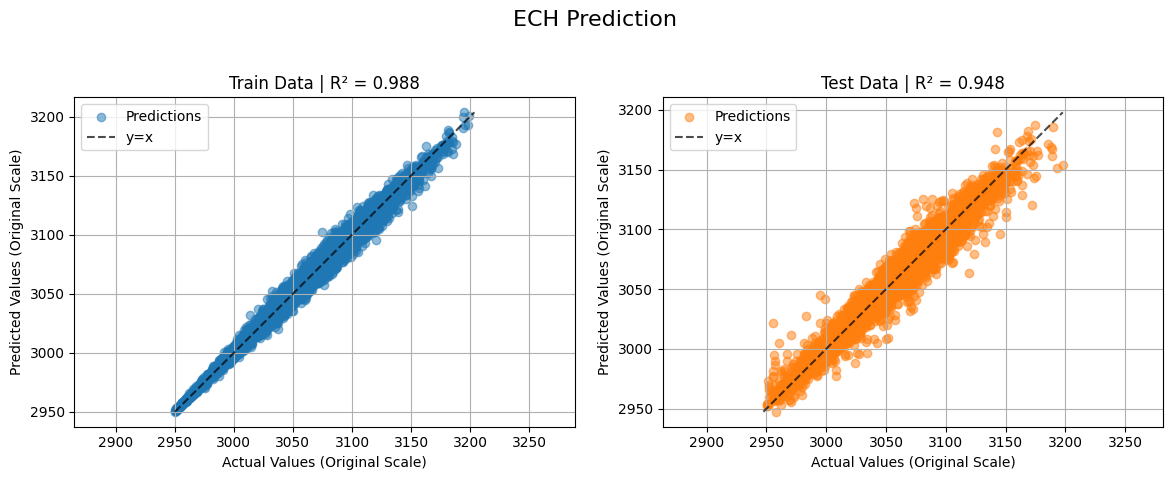


--- Evaluation for PVC Waste Prediction ---
Train R²: 0.9937 | Test R²: 0.9792


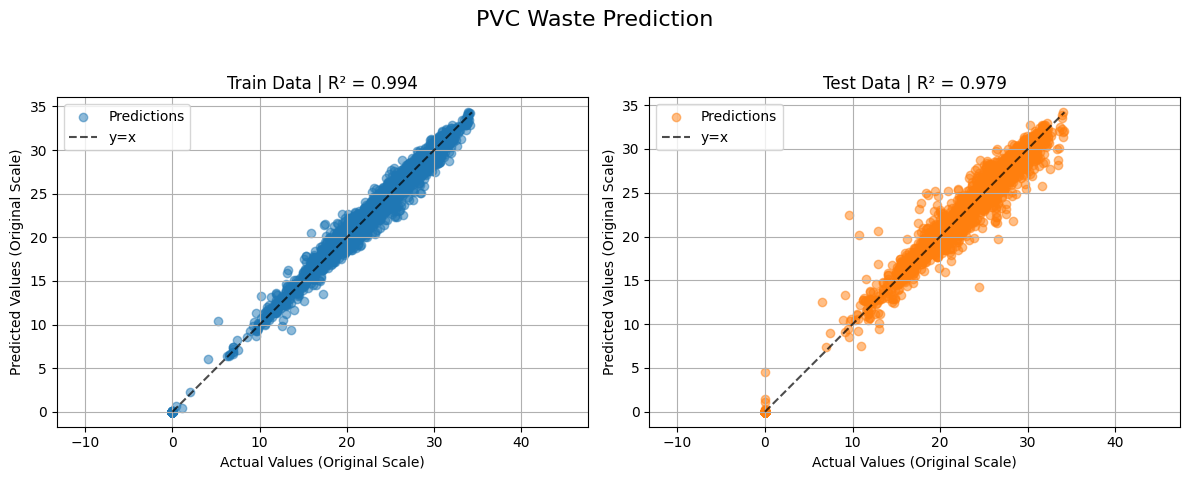

In [8]:
evaluate_pmc_model(model_ech, x_scaler_ech, y_scaler_ech, X_train_ech, y_train_ech, X_test_ech, y_test_ech, title="ECH Prediction")
evaluate_pmc_model(model_waste, x_scaler_waste, y_scaler_waste, X_train_waste, y_train_waste, X_test_waste, y_test_waste, title="PVC Waste Prediction")

In [ ]:
import pandas as pd
import numpy as np
import torch
from scipy.optimize import minimize
import matplotlib.pyplot as plt

X_all = df.drop(columns=['ECH_target', waste_col])
y_all_ech = df['ECH_target']
y_all_waste = df[waste_col]

control_tags = df_ctrl['tag'].tolist()
control_indices = [tag for tag in X_all.columns if tag in control_tags]
bounds = [tuple(df_ctrl[df_ctrl['tag'] == tag][['min', 'max']].values[0]) for tag in control_indices]
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model_ech.eval()
model_waste.eval()

optimized_ech_preds = []
optimized_waste_preds = []
optimized_controls_list = []


total_len = len(X_all)
start_index = int(total_len * 0.7)

print(f"Starting multi-objective optimization for the last 20% of data ({start_index} to {total_len-1})...")

for i in range(start_index, total_len):
    env_row = X_all.iloc[i].copy()
    
    lam = 0.6

    def objective(control_vals):
        x_input = env_row.copy()
        for j, tag in enumerate(control_indices):
            x_input[tag] = control_vals[j]
        
        x_ech_scaled = x_scaler_ech.transform(pd.DataFrame([x_input]))
        x_waste_scaled = x_scaler_waste.transform(pd.DataFrame([x_input]))
        
        with torch.no_grad():
            pred_ech_norm = model_ech(torch.tensor(x_ech_scaled, dtype=torch.float32).to(device)).cpu().item()
            pred_waste_norm = model_waste(torch.tensor(x_waste_scaled, dtype=torch.float32).to(device)).cpu().item()
            
        return -(pred_ech_norm - lam * pred_waste_norm)

    x0 = np.array([env_row[tag] for tag in control_indices])
    res = minimize(objective, x0=x0, bounds=bounds, method='L-BFGS-B')
    
    optimized_control_vals = res.x
    final_input = env_row.copy()
    for j, tag in enumerate(control_indices):
        final_input[tag] = optimized_control_vals[j]
        
    x_ech_scaled_final = x_scaler_ech.transform(pd.DataFrame([final_input]))
    x_waste_scaled_final = x_scaler_waste.transform(pd.DataFrame([final_input]))
    
    with torch.no_grad():
        final_pred_ech_scaled = model_ech(torch.tensor(x_ech_scaled_final, dtype=torch.float32).to(device)).cpu().numpy()
        final_pred_waste_scaled = model_waste(torch.tensor(x_waste_scaled_final, dtype=torch.float32).to(device)).cpu().numpy()

    final_pred_ech = y_scaler_ech.inverse_transform(final_pred_ech_scaled)[0, 0]
    final_pred_waste = y_scaler_waste.inverse_transform(final_pred_waste_scaled)[0, 0]

    optimized_ech_preds.append(final_pred_ech)
    optimized_waste_preds.append(final_pred_waste)
    optimized_controls_list.append(optimized_control_vals)
    
    if (i - start_index + 1) % 100 == 0:
         print(f"[{i+1}/{total_len}] ECH: {y_all_ech[i]:.2f} -> {final_pred_ech:.2f}, WASTE: {y_all_waste[i]:.2f} -> {final_pred_waste:.2f}")

print("\nOptimization for the last 20% of data is complete.")

In [15]:
def plot_hybrid_result(y_all, optimized_tail_preds, title="Hybrid Optimization Effect", ylabel="Target"):
    split_idx = int(0.7 * len(y_all))
    original_series = y_all[:split_idx]
    
    hybrid_series = np.concatenate([
        original_series,           
        np.array(optimized_tail_preds)
    ])
    
    original_tail = y_all[split_idx:]

    mean_before = np.mean(original_series)
    mean_after = np.mean(optimized_tail_preds)

    plt.figure(figsize=(14, 5))
    plt.plot(hybrid_series, label="Hybrid (Optimized Last 20%)", color='blue')
    plt.plot(np.arange(split_idx), original_series, label="Original (First 80%)", color='red')
    plt.plot(np.arange(split_idx, len(y_all)), original_tail, label="Original (Last 20%)", color='gray', linestyle='--')
    plt.axvline(split_idx, color='black', linestyle=':', label="80% split")
    plt.hlines(mean_before, 0, split_idx, color='blue', linestyle='-', label="Before Avg")
    plt.hlines(mean_after, split_idx, len(y_all), color='red', linestyle='-', label="After Avg")
    plt.text(split_idx / 2, mean_before + 0.3, 'Before', color='blue', ha='center')
    plt.text(split_idx + (len(y_all) - split_idx)/2, mean_after + 0.3, 'After', color='red', ha='center')
    plt.title(title)
    plt.xlabel("Index")
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()


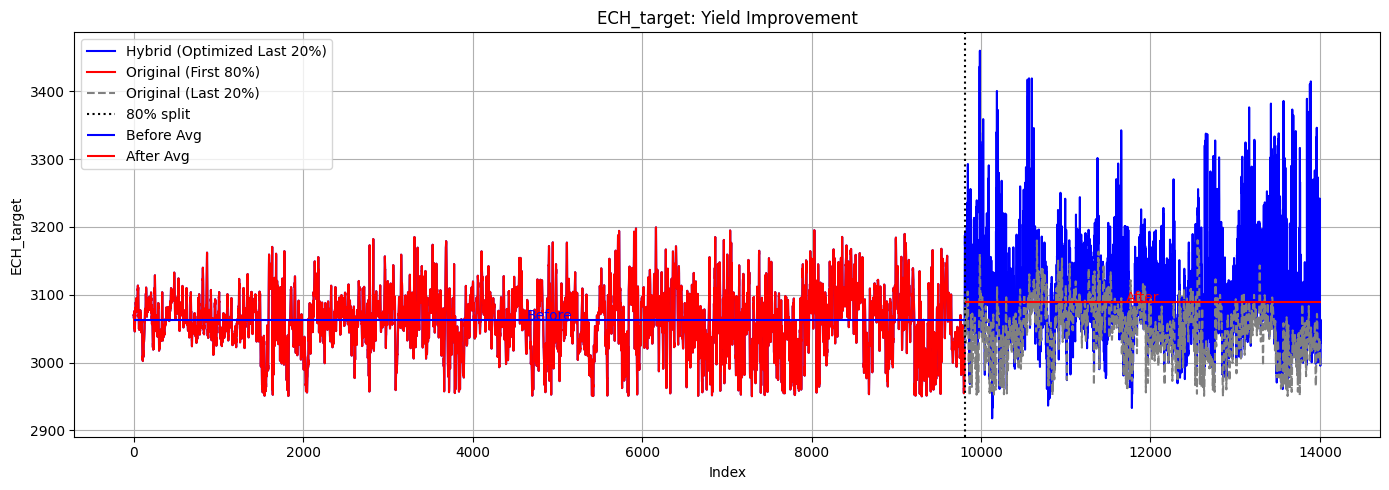

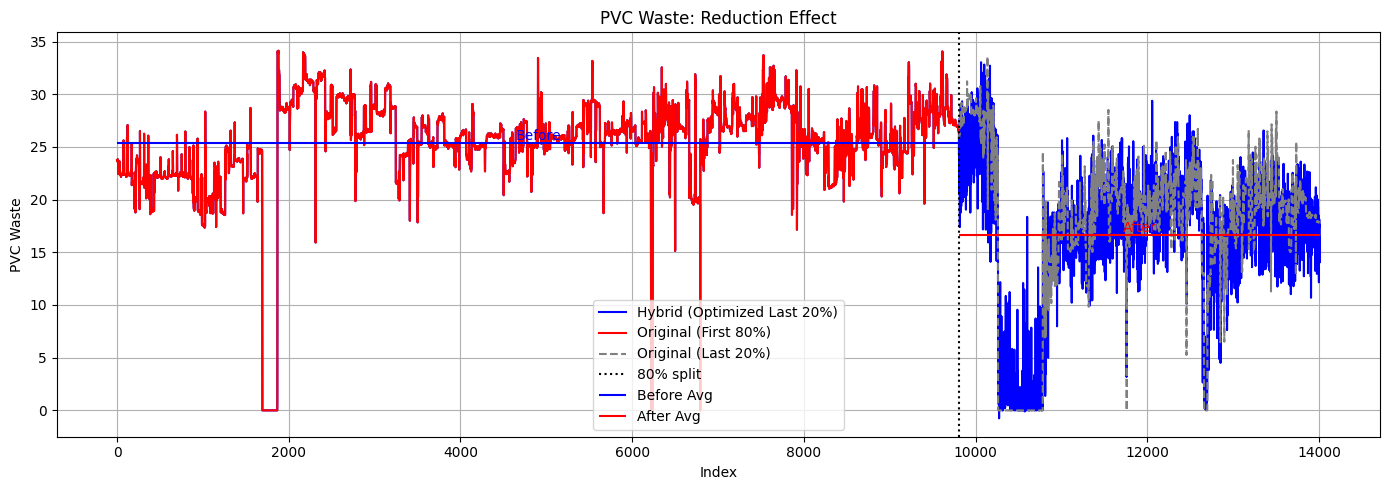

In [16]:
plot_hybrid_result(y_all_ech, optimized_ech_preds, title="ECH_target: Yield Improvement", ylabel="ECH_target")
plot_hybrid_result(y_all_waste, optimized_waste_preds, title="PVC Waste: Reduction Effect", ylabel="PVC Waste")

In [17]:
import numpy as np
split_idx = int(0.7 * len(X_all))

mean_original_ech = np.mean(y_all_ech[split_idx:])
mean_optimized_ech = np.mean(optimized_ech_preds)
ech_improvement = mean_optimized_ech - mean_original_ech
ech_improvement_rate = (ech_improvement / mean_original_ech) * 100

mean_original_waste = np.mean(y_all_waste[split_idx:])
mean_optimized_waste = np.mean(optimized_waste_preds)
waste_reduction = mean_optimized_waste - mean_original_waste
waste_reduction_rate = (waste_reduction / mean_original_waste) * 100

print("\n--- Multi-Objective Optimization Results ---")
print(" **ECH (Yield) Analysis:**")
print(f"  - Original Average: {mean_original_ech:.4f}")
print(f"  - Optimized Average: {mean_optimized_ech:.4f}")
print(f"  - **Improvement Rate: {ech_improvement_rate:+.2f}%**")

print("\n **WASTE Analysis:**")
print(f"  - Original Average: {mean_original_waste:.4f}")
print(f"  - Optimized Average: {mean_optimized_waste:.4f}")
print(f"  - **Reduction Rate: {waste_reduction_rate:+.2f}%**")


--- Multi-Objective Optimization Results ---
 **ECH (Yield) Analysis:**
  - Original Average: 3047.7031
  - Optimized Average: 3088.7944
  - **Improvement Rate: +1.35%**

 **WASTE Analysis:**
  - Original Average: 17.1236
  - Optimized Average: 16.5996
  - **Reduction Rate: -3.06%**


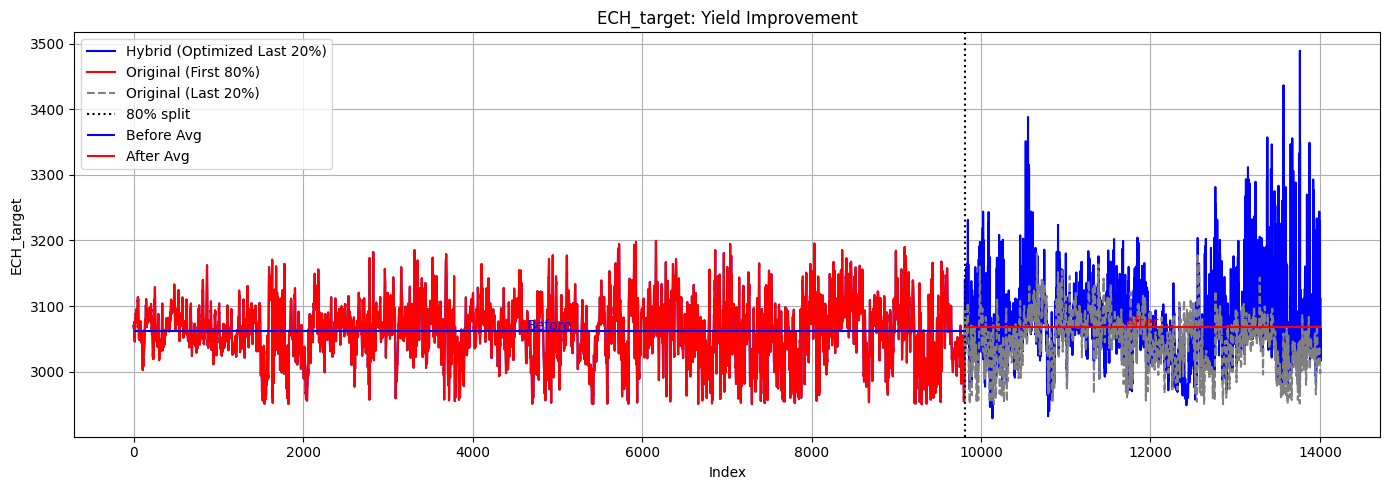

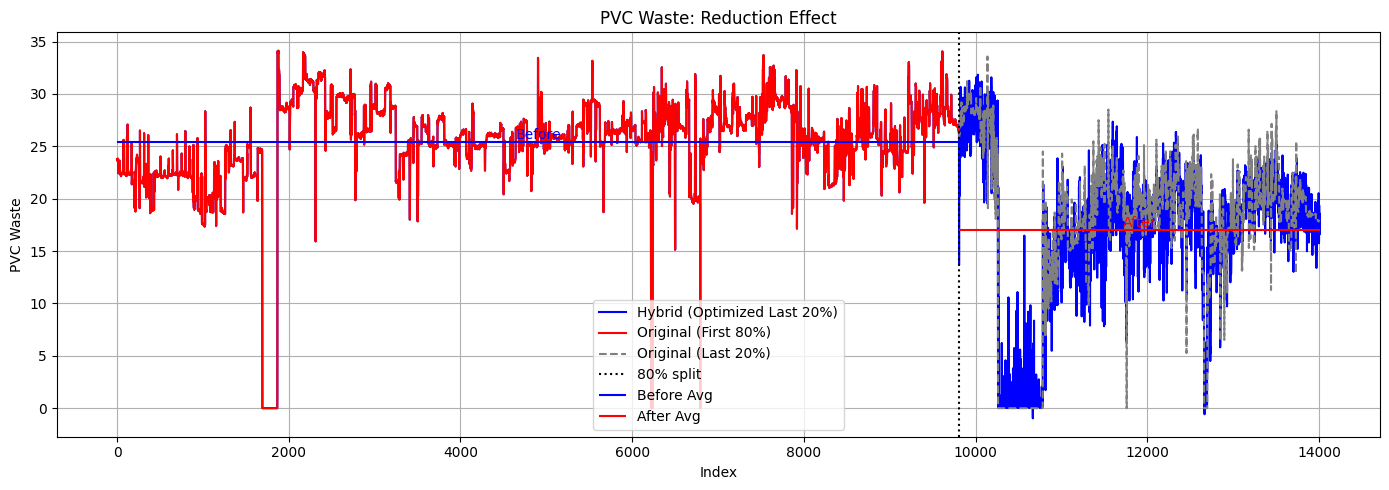

In [ ]:
plot_hybrid_result(y_all_ech, optimized_ech_preds, title="ECH_target: Yield Improvement", ylabel="ECH_target")
plot_hybrid_result(y_all_waste, optimized_waste_preds, title="PVC Waste: Reduction Effect", ylabel="PVC Waste")

In [ ]:
import numpy as np
split_idx = int(0.7 * len(X_all))

mean_original_ech = np.mean(y_all_ech[split_idx:])
mean_optimized_ech = np.mean(optimized_ech_preds)
ech_improvement = mean_optimized_ech - mean_original_ech
ech_improvement_rate = (ech_improvement / mean_original_ech) * 100

mean_original_waste = np.mean(y_all_waste[split_idx:])
mean_optimized_waste = np.mean(optimized_waste_preds)
waste_reduction = mean_optimized_waste - mean_original_waste
waste_reduction_rate = (waste_reduction / mean_original_waste) * 100

print("\n--- Multi-Objective Optimization Results ---")
print(" **ECH (Yield) Analysis:**")
print(f"  - Original Average: {mean_original_ech:.4f}")
print(f"  - Optimized Average: {mean_optimized_ech:.4f}")
print(f"  - **Improvement Rate: {ech_improvement_rate:+.2f}%**")

print("\n **WASTE Analysis:**")
print(f"  - Original Average: {mean_original_waste:.4f}")
print(f"  - Optimized Average: {mean_optimized_waste:.4f}")
print(f"  - **Reduction Rate: {waste_reduction_rate:+.2f}%**")


--- Multi-Objective Optimization Results ---
 **ECH (Yield) Analysis:**
  - Original Average: 3047.7031
  - Optimized Average: 3068.3064
  - **Improvement Rate: +0.68%**

 **WASTE Analysis:**
  - Original Average: 17.1236
  - Optimized Average: 17.0352
  - **Reduction Rate: -0.52%**


In [143]:
import pandas as pd
import numpy as np
import torch
from scipy.optimize import minimize
import matplotlib.pyplot as plt

X_all = df.drop(columns=['ECH_target', waste_col])
y_all_ech = df['ECH_target']
y_all_waste = df[waste_col]

control_tags = df_ctrl['tag'].tolist()
control_indices = [tag for tag in X_all.columns if tag in control_tags]
bounds = [tuple(df_ctrl[df_ctrl['tag'] == tag][['min', 'max']].values[0]) for tag in control_indices]
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model_ech.eval()
model_waste.eval()

optimized_ech_preds = []
optimized_waste_preds = []
optimized_controls_list = []


total_len = len(X_all)
start_index = int(total_len * 0.8)

print(f"Starting multi-objective optimization for the last 20% of data ({start_index} to {total_len-1})...")

for i in range(start_index, total_len):
    env_row = X_all.iloc[i].copy()
    
    lam = 0.2

    def objective(control_vals):
        x_input = env_row.copy()
        for j, tag in enumerate(control_indices):
            x_input[tag] = control_vals[j]
        
        x_ech_scaled = x_scaler_ech.transform(pd.DataFrame([x_input]))
        x_waste_scaled = x_scaler_waste.transform(pd.DataFrame([x_input]))
        
        with torch.no_grad():
            pred_ech_norm = model_ech(torch.tensor(x_ech_scaled, dtype=torch.float32).to(device)).cpu().item()
            pred_waste_norm = model_waste(torch.tensor(x_waste_scaled, dtype=torch.float32).to(device)).cpu().item()
            
        return -(pred_ech_norm - lam * pred_waste_norm)

    x0 = np.array([env_row[tag] for tag in control_indices])
    res = minimize(objective, x0=x0, bounds=bounds, method='L-BFGS-B')
    
    optimized_control_vals = res.x
    final_input = env_row.copy()
    for j, tag in enumerate(control_indices):
        final_input[tag] = optimized_control_vals[j]
        
    x_ech_scaled_final = x_scaler_ech.transform(pd.DataFrame([final_input]))
    x_waste_scaled_final = x_scaler_waste.transform(pd.DataFrame([final_input]))
    
    with torch.no_grad():
        final_pred_ech_scaled = model_ech(torch.tensor(x_ech_scaled_final, dtype=torch.float32).to(device)).cpu().numpy()
        final_pred_waste_scaled = model_waste(torch.tensor(x_waste_scaled_final, dtype=torch.float32).to(device)).cpu().numpy()

    final_pred_ech = y_scaler_ech.inverse_transform(final_pred_ech_scaled)[0, 0]
    final_pred_waste = y_scaler_waste.inverse_transform(final_pred_waste_scaled)[0, 0]

    optimized_ech_preds.append(final_pred_ech)
    optimized_waste_preds.append(final_pred_waste)
    optimized_controls_list.append(optimized_control_vals)
    
    if (i - start_index + 1) % 100 == 0:
         print(f"[{i+1}/{total_len}] ECH: {y_all_ech[i]:.2f} -> {final_pred_ech:.2f}, WASTE: {y_all_waste[i]:.2f} -> {final_pred_waste:.2f}")

print("\nOptimization for the last 20% of data is complete.")

Starting multi-objective optimization for the last 20% of data (11207 to 14008)...
[11307/14009] ECH: 3082.72 -> 3080.66, WASTE: 11.82 -> 12.92
[11407/14009] ECH: 3069.35 -> 3074.81, WASTE: 18.81 -> 19.80
[11507/14009] ECH: 3104.73 -> 3073.92, WASTE: 21.74 -> 20.61
[11607/14009] ECH: 3062.40 -> 3063.54, WASTE: 21.01 -> 23.21
[11707/14009] ECH: 3047.28 -> 3095.01, WASTE: 20.81 -> 21.42
[11807/14009] ECH: 3044.98 -> 3077.95, WASTE: 17.03 -> 15.14
[11907/14009] ECH: 3098.02 -> 3081.56, WASTE: 19.75 -> 21.00
[12007/14009] ECH: 3067.50 -> 3062.69, WASTE: 18.78 -> 17.80
[12107/14009] ECH: 3064.56 -> 3068.76, WASTE: 23.92 -> 22.62
[12207/14009] ECH: 3035.56 -> 2993.15, WASTE: 21.48 -> 23.60
[12307/14009] ECH: 3016.19 -> 3016.28, WASTE: 20.40 -> 22.35
[12407/14009] ECH: 3015.63 -> 2967.83, WASTE: 17.38 -> 17.12
[12507/14009] ECH: 3066.17 -> 3053.28, WASTE: 20.07 -> 20.21
[12607/14009] ECH: 2999.75 -> 3017.78, WASTE: 19.43 -> 19.69
[12707/14009] ECH: 2998.88 -> 3027.28, WASTE: 11.97 -> 12.36
[1

In [ ]:
def plot_hybrid_result(y_all, optimized_tail_preds, title="Hybrid Optimization Effect", ylabel="Target"):
    split_idx = int(0.8 * len(y_all))
    original_series = y_all[:split_idx]
    
    hybrid_series = np.concatenate([
        original_series,           
        np.array(optimized_tail_preds) 
    ])
    
    original_tail = y_all[split_idx:]

    mean_before = np.mean(original_series)
    mean_after = np.mean(optimized_tail_preds)

    plt.figure(figsize=(14, 5))
    plt.plot(hybrid_series, label="Hybrid (Optimized Last 20%)", color='blue')
    plt.plot(np.arange(split_idx), original_series, label="Original (First 80%)", color='red')
    plt.plot(np.arange(split_idx, len(y_all)), original_tail, label="Original (Last 20%)", color='gray', linestyle='--')
    plt.axvline(split_idx, color='black', linestyle=':', label="80% split")
    plt.hlines(mean_before, 0, split_idx, color='blue', linestyle='-', label="Before Avg")
    plt.hlines(mean_after, split_idx, len(y_all), color='red', linestyle='-', label="After Avg")
    plt.text(split_idx / 2, mean_before + 0.3, 'Before', color='blue', ha='center')
    plt.text(split_idx + (len(y_all) - split_idx)/2, mean_after + 0.3, 'After', color='red', ha='center')
    plt.title(title)
    plt.xlabel("Index")
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()


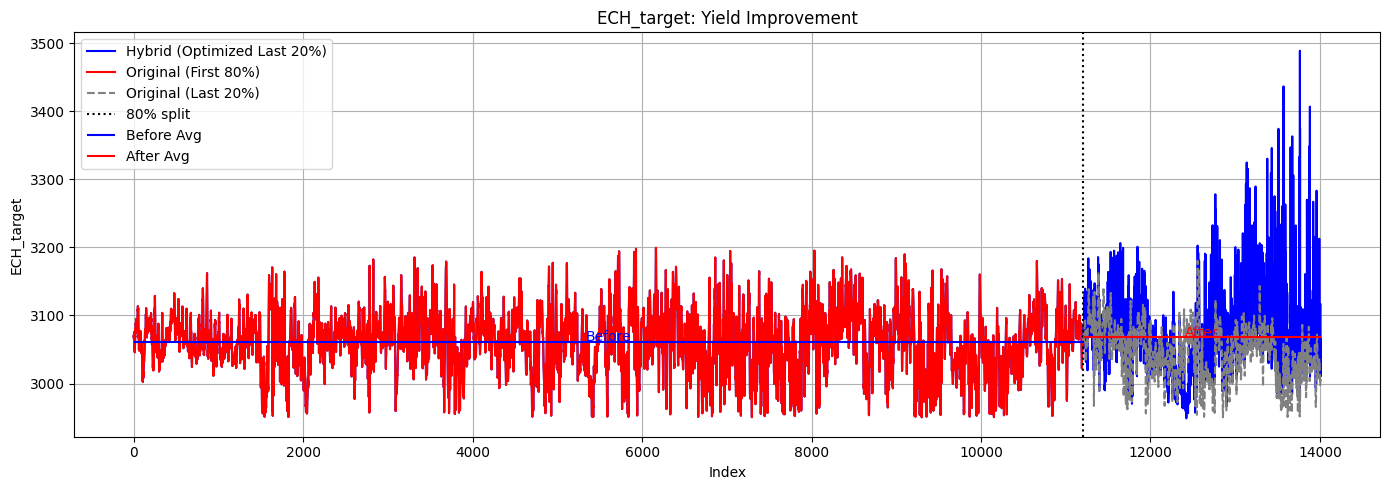

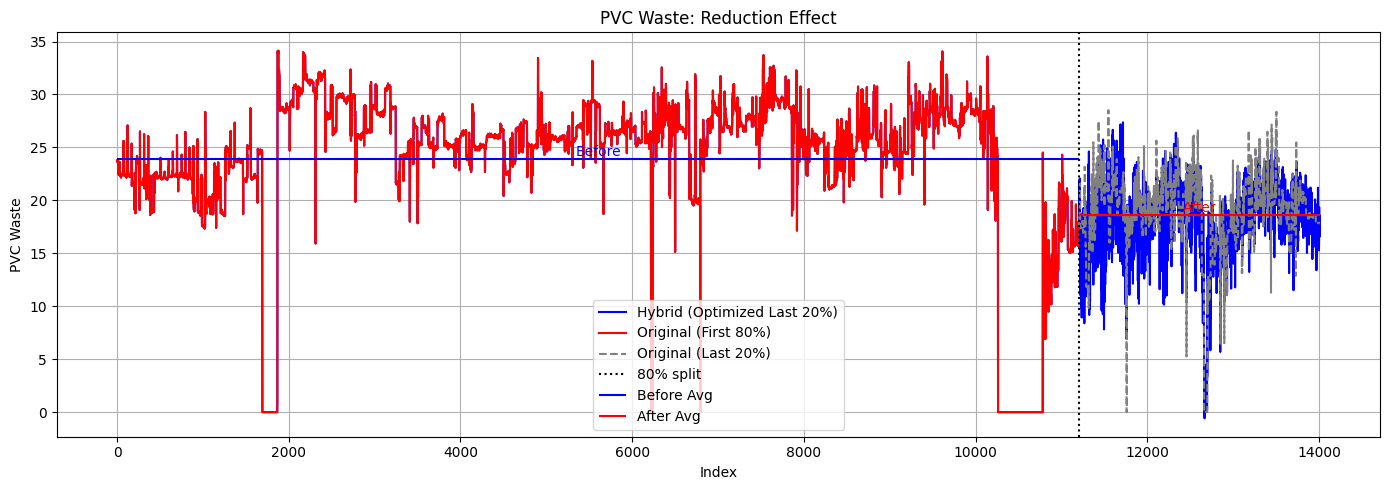

In [145]:
plot_hybrid_result(y_all_ech, optimized_ech_preds, title="ECH_target: Yield Improvement", ylabel="ECH_target")
plot_hybrid_result(y_all_waste, optimized_waste_preds, title="PVC Waste: Reduction Effect", ylabel="PVC Waste")

In [146]:
import numpy as np
split_idx = int(0.8 * len(X_all))

mean_original_ech = np.mean(y_all_ech[split_idx:])
mean_optimized_ech = np.mean(optimized_ech_preds)
ech_improvement = mean_optimized_ech - mean_original_ech
ech_improvement_rate = (ech_improvement / mean_original_ech) * 100

mean_original_waste = np.mean(y_all_waste[split_idx:])
mean_optimized_waste = np.mean(optimized_waste_preds)
waste_reduction = mean_optimized_waste - mean_original_waste
waste_reduction_rate = (waste_reduction / mean_original_waste) * 100

print("\n--- Multi-Objective Optimization Results ---")
print(" **ECH (Yield) Analysis:**")
print(f"  - Original Average: {mean_original_ech:.4f}")
print(f"  - Optimized Average: {mean_optimized_ech:.4f}")
print(f"  - **Improvement Rate: {ech_improvement_rate:+.2f}%**")

print("\n **WASTE Analysis:**")
print(f"  - Original Average: {mean_original_waste:.4f}")
print(f"  - Optimized Average: {mean_optimized_waste:.4f}")
print(f"  - **Reduction Rate: {waste_reduction_rate:+.2f}%**")


--- Multi-Objective Optimization Results ---
 **ECH (Yield) Analysis:**
  - Original Average: 3045.1114
  - Optimized Average: 3067.8020
  - **Improvement Rate: +0.75%**

 **WASTE Analysis:**
  - Original Average: 18.9070
  - Optimized Average: 18.5752
  - **Reduction Rate: -1.75%**
